In [5]:
from utils import parse_xml
import string
import re
import nltk

stopwords = nltk.corpus.stopwords.words('english')

# Specify the path to your XML file
xml_file_path = r'C:\dev\NLP-Sandbox\PURE\requirements-xml\0000 - cctns.xml'
# Define the namespace
namespace = {'ns': 'req_document.xsd'}

# import utils.ParseXML as ParseXML
df = parse_xml.process_xml_with_namespace(xml_file_path, namespace)


In [6]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


In [ ]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and
             title(initial 100 words considred as title of document)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

Total Number of Documents: 154


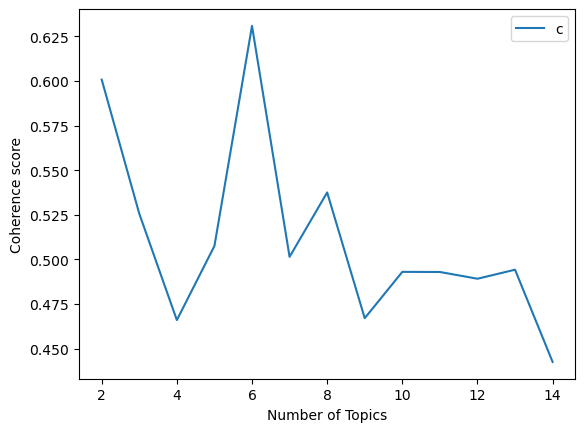

In [12]:
def load_data_from_dataframe(df, text_column):
    """
    Input  : DataFrame and the name of the column containing the text
    Purpose: Extract text data from a DataFrame
    Output : List of paragraphs/documents and titles (initial 100 words considered as title of document)
    """
    documents_list = df[text_column].tolist()
    titles = [text[:min(len(text), 100)] for text in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles


def preprocess_data(doc_set):
    """
    Input  : Document list
    Purpose: Preprocess text (tokenize, remove stopwords, and stemming)
    Output : Preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []

    for text in doc_set:
        raw = text.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [word for word in tokens if word not in en_stop]
        stemmed_tokens = [p_stemmer.stem(word) for word in stopped_tokens]
        texts.append(stemmed_tokens)

    return texts


def prepare_corpus(doc_clean):
    """
    Input  : Clean document
    Purpose: Create a term dictionary of our corpus and Convert a list of documents (corpus) into Document Term Matrix
    Output : Term dictionary and Document Term Matrix
    """
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix


def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Input  : Clean document, number of topics, and number of words associated with each topic
    Purpose: Create LSA model using gensim
    Output : Return LSA model
    """
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : Gensim dictionary, Gensim corpus, List of input texts, Max num of topics
    Purpose : Compute c_v coherence for various numbers of topics
    Output  : List of LSA topic models, Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start, step)

    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


# Usage example:
text_column = "text"  # Specify the name of the column containing the text
documents_list, titles = load_data_from_dataframe(df, text_column)
clean_text = preprocess_data(documents_list)
start, stop, step = 2, 15, 1
plot_graph(clean_text, start, stop, step)


In [16]:
# LSA Model
number_of_topics=6
words=10
# Usage example:
text_column = "text"  # Specify the name of the column containing the text
documents_list, titles = load_data_from_dataframe(df, text_column)
clean_text = preprocess_data(documents_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)


Total Number of Documents: 154
[(0, '-0.735*"user" + -0.229*"use" + -0.213*"page" + -0.160*"access" + -0.148*"inform" + -0.142*"interfac" + -0.142*"system" + -0.132*"content" + -0.127*"differ" + -0.127*"provid"'), (1, '-0.632*"page" + 0.386*"user" + -0.260*"iso" + -0.208*"9241" + -0.181*"use" + -0.115*"link" + -0.112*"guidanc" + -0.106*"applic" + -0.098*"present" + 0.098*"adapt"'), (2, '0.450*"system" + -0.365*"page" + 0.217*"function" + 0.191*"case" + 0.170*"iso" + 0.167*"must" + -0.160*"user" + 0.152*"access" + 0.149*"servic" + 0.136*"9241"'), (3, '-0.442*"iso" + -0.353*"9241" + 0.273*"system" + 0.265*"page" + 0.183*"use" + -0.178*"guidanc" + 0.171*"search" + 0.164*"case" + -0.138*"design" + -0.129*"present"'), (4, '-0.276*"servic" + -0.268*"compon" + -0.263*"function" + 0.253*"system" + -0.224*"architectur" + -0.220*"core" + -0.198*"state" + 0.182*"case" + -0.172*"custom" + -0.172*"configur"'), (5, '-0.372*"use" + 0.335*"system" + -0.296*"search" + 0.250*"page" + -0.196*"polic" + 0.